<a href="https://colab.research.google.com/github/harithadam/resnet_image_recognition/blob/main/resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

Define transformation pipeline

- converts PIL image / numpy.ndarray into a Pytorch tensor
- scales pixel values from [0, 255] to [0.0, 1.0]
- normalize from [0, 1] to [-1, +1]

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

Load CIFAR-10 Dataset, split to train/test sets

In [ ]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)

100%|██████████| 170M/170M [00:08<00:00, 20.3MB/s]


In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

Load Pretrained ResNet18

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights

# Load the pretrained model properly
weights = ResNet18_Weights.DEFAULT  # or IMAGENET1K_V1
model = resnet18(weights=weights)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 105MB/s]


Adapt for 10 outputs

In [ ]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

Define training settings

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Model Training

In [ ]:
for epoch in range(5):  # Train for 5 epochs
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

Epoch 1, Loss: 0.9516844342812858
Epoch 2, Loss: 0.6493884536730664
Epoch 3, Loss: 0.510208270376753
Epoch 4, Loss: 0.4296381424188309
Epoch 5, Loss: 0.35022674482839794


In [ ]:
correct = 0
total = 0
model.eval()  # set model to evaluation mode (no dropout, batchnorm frozen)

with torch.no_grad():  # no need to track gradients during inference
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total:.2f}%')


Accuracy: 79.52%


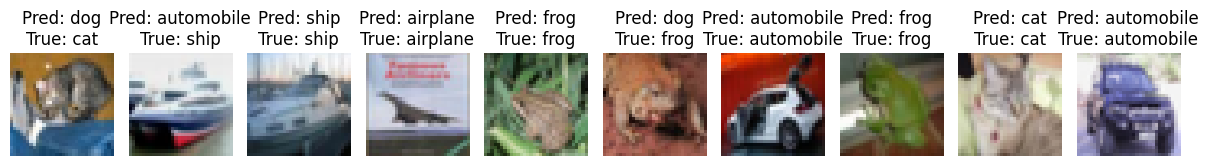

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# CIFAR-10 class names
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# Function to unnormalize and convert tensor to numpy image
def imshow(img):
    img = img / 2 + 0.5  # reverse normalization: [-1, 1] → [0, 1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # CHW → HWC
    plt.axis('off')

# Get 1 batch of test images (64 images)
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Select the first 5 images
images = images[:10]
labels = labels[:10]

# Move to same device as model
images = images.to(device)
labels = labels.to(device)

# Set model to evaluation mode
model.eval()

# Make predictions (no gradient tracking needed)
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Plot the 5 images with predictions
plt.figure(figsize=(12, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    imshow(images[i].cpu())
    plt.title(f'Pred: {classes[predicted[i]]}\nTrue: {classes[labels[i]]}')
plt.tight_layout()
plt.show()
